In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s


# load data
data = np.loadtxt('i_direct_flux')
ids = data[0, :]
dfs = data[1:, :]

In [ ]:
def func_ord_6(x, g, f, e, a, b, c, d):
    return g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_5(x, f, e, a, b, c, d):
    return f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_4(x, e, a, b, c, d):
    return e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_3(x, a, b, c, d):
    return a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_2(x, a, b, c):
    return a * (x**2) + b * x  + c
  
    
def plot_original(iq_idx):
    df = dfs[:, iq_idx]    
    # plot original points     
    plt.plot(ids, df, label = 'original', color = 'black')
    plt.scatter(ids, df, color = 'black')

def plot_curve_iq(iq_idx, func, func_descr='', label=''):
     
    df = dfs[:, iq_idx]    
    # fit curve to points     
    w, pcov = curve_fit(func, ids, df)
    
    # compute error
    df_pred = func(ids, *w)
    error = (1 / len(ids)) * sum((df_pred - df) ** 2)
    
    # predict new points     
    x = np.arange(0, 240, 20)
    y_pred = func(x, *w)
    
    plt.plot(x, y_pred,label = label)
    plt.scatter(x, y_pred)
    
    plt.title(' %s error: %.8f' % (func_descr, error))
    plt.ylim([0, 0.25])
    plt.xlim([0, 220])
    plt.xticks(ids)
    plt.xlabel('id')
    plt.ylabel('direct flux')
    #plt.grid()
    #plt.show()
    return error
        
funcs = [
    func_ord_6, 
    func_ord_5, 
#     func_ord_4, 
#     func_ord_3, 
#     func_ord_2
]
dex = {
    func_ord_6 : 'y=f(x**6)',
    func_ord_5 : 'y=f(x**5)', 
    func_ord_4 : 'y=f(x**4)',
    func_ord_3 : 'y=f(x**3)',
    func_ord_2 : 'y=f(x**2)',
}

curve_indices = list(range(0, 12)) 
curve_for_plot = [6]

# Get current size
plt.rcParams["figure.figsize"] = [12, 8]
    
headers = ['curve'] + [dex[func] for func in funcs]
rows    = []

for curve_idx in curve_indices:
    plt.clf()
    
    row = ['curve: %d' % curve_idx]
    for func in funcs:
        error = plot_curve_iq(curve_idx, func, 'curve: %d' % curve_idx, dex[func])
        row.append(error * 10000)
    rows.append(row)
    
    if curve_idx not in curve_for_plot:
        continue
        
    plot_original(curve_idx)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

table = plotTable(headers=headers, rows=rows, precision=3)
print(table)

curve: 1, pts num: 6


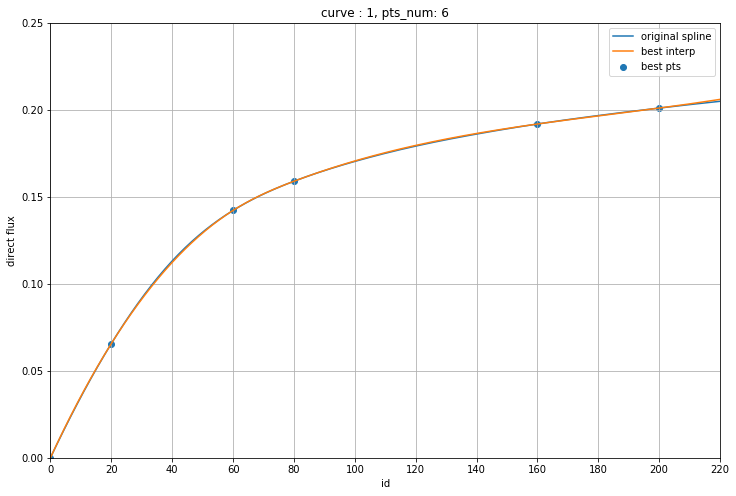

curve: 1, pts num: 5


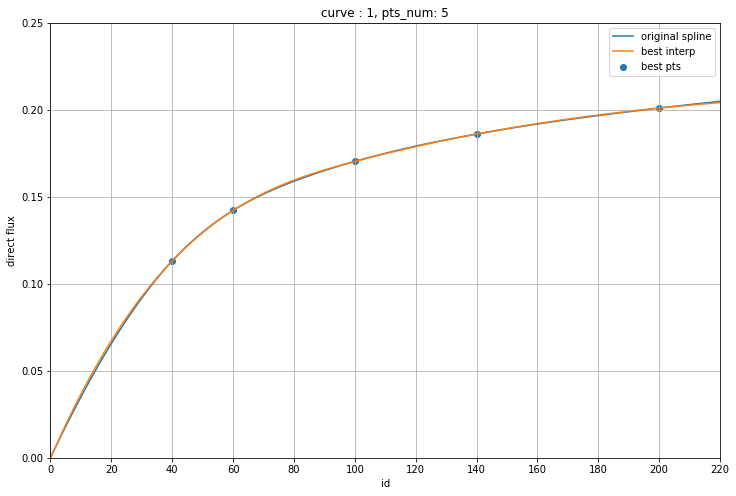

curve: 1, pts num: 4


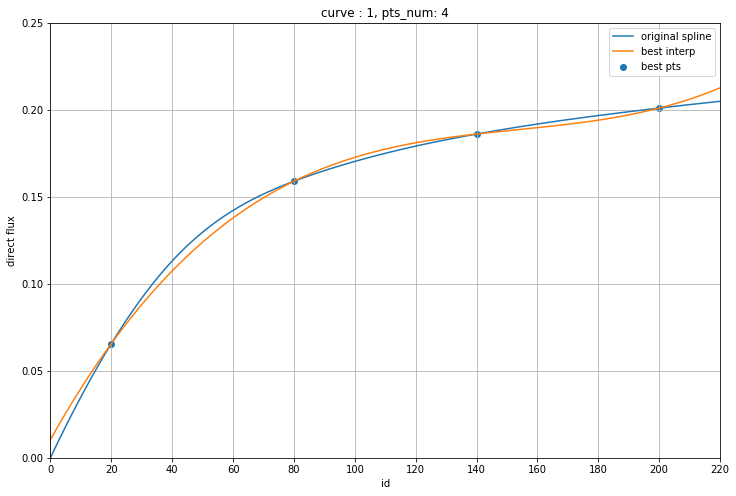

curve: 3, pts num: 6


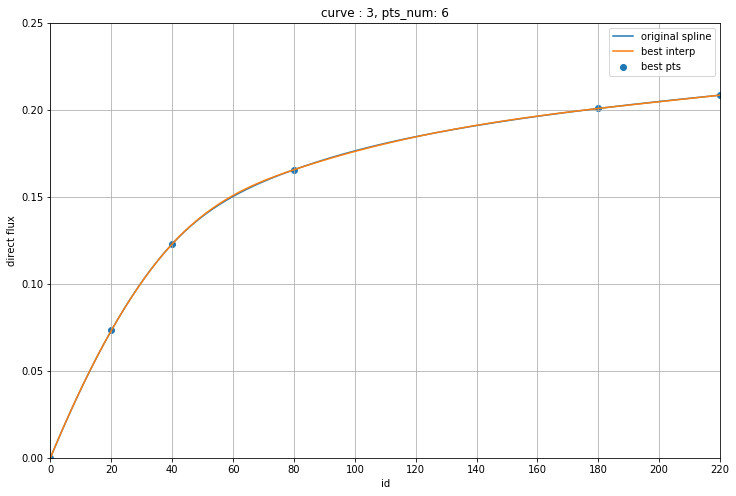

curve: 3, pts num: 5


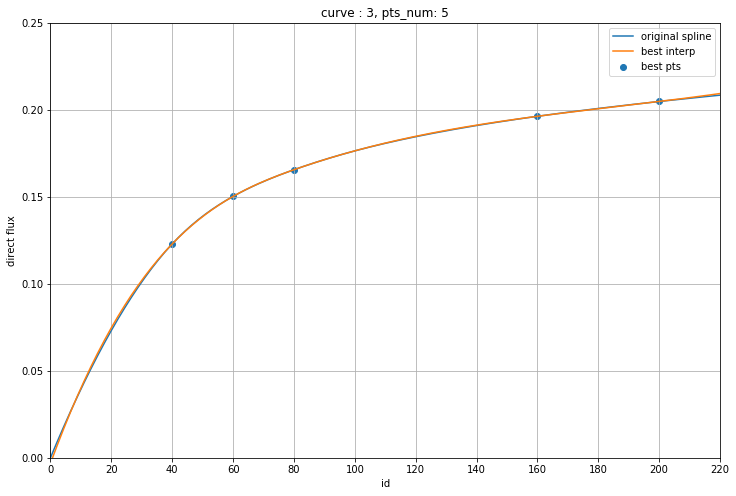

curve: 3, pts num: 4


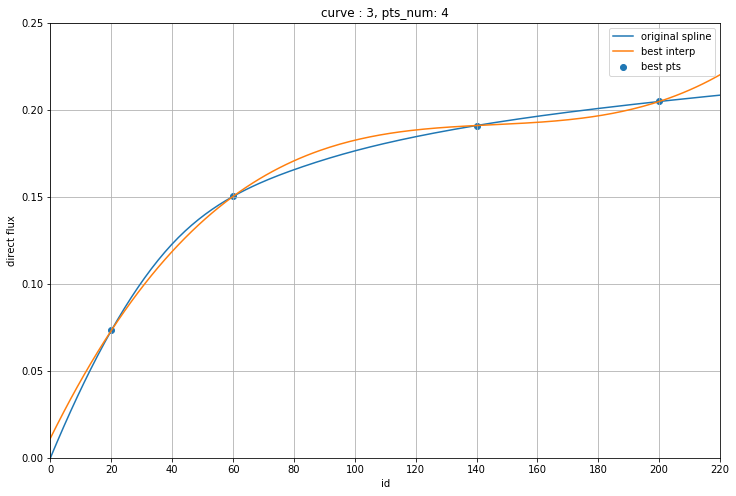

curve: 5, pts num: 6


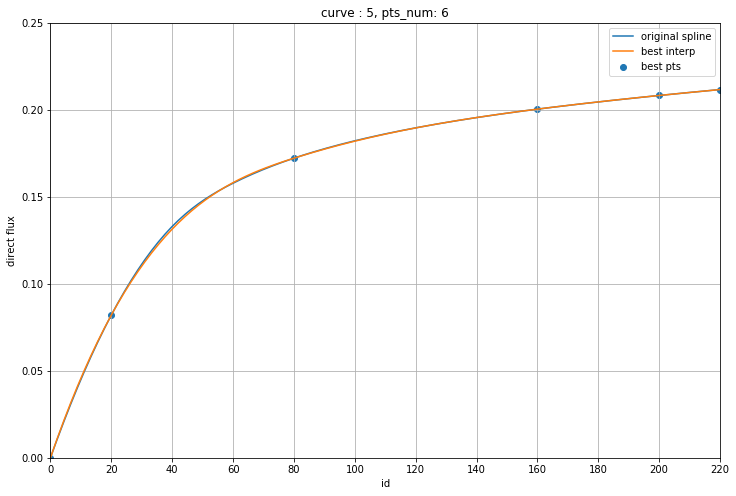

curve: 5, pts num: 5


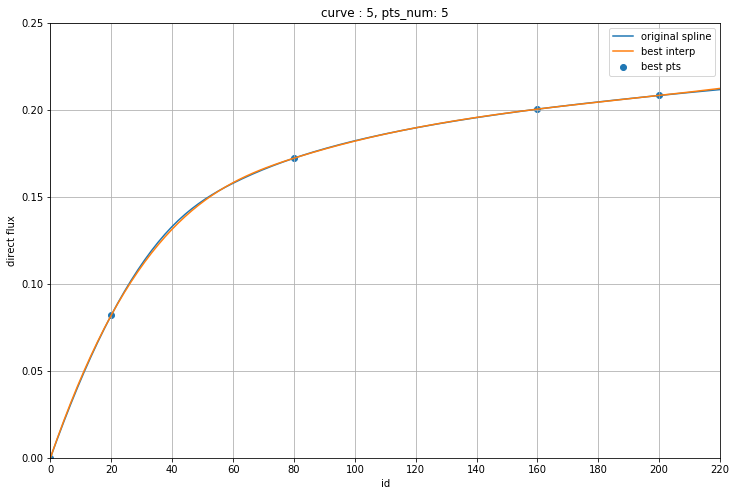

curve: 5, pts num: 4


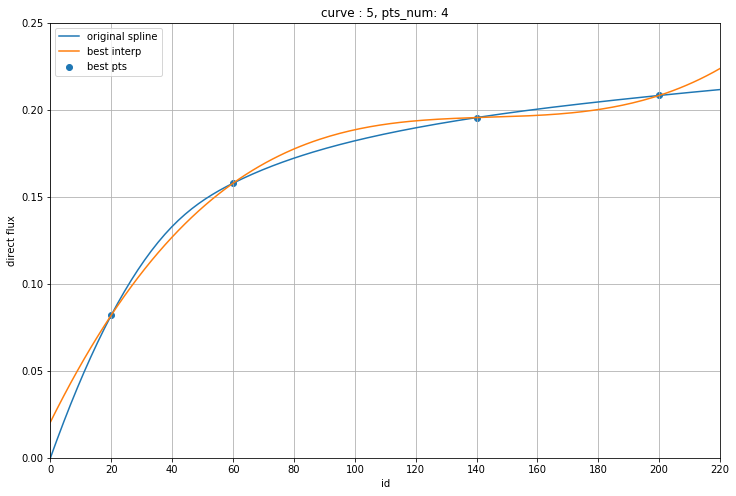

curve: 7, pts num: 6


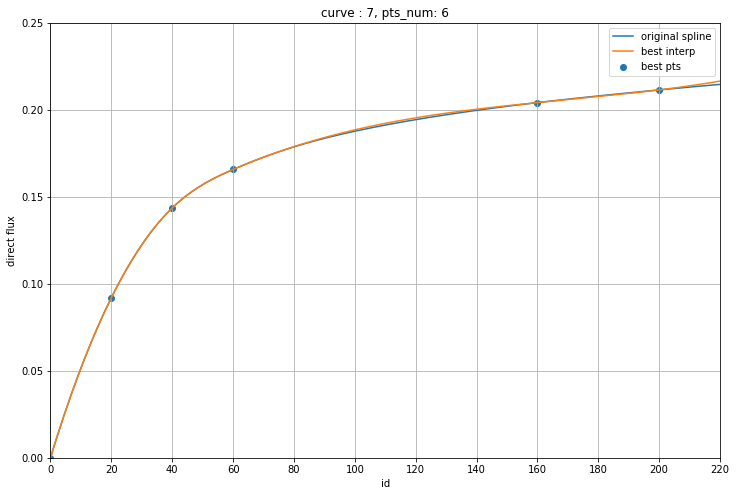

curve: 7, pts num: 5


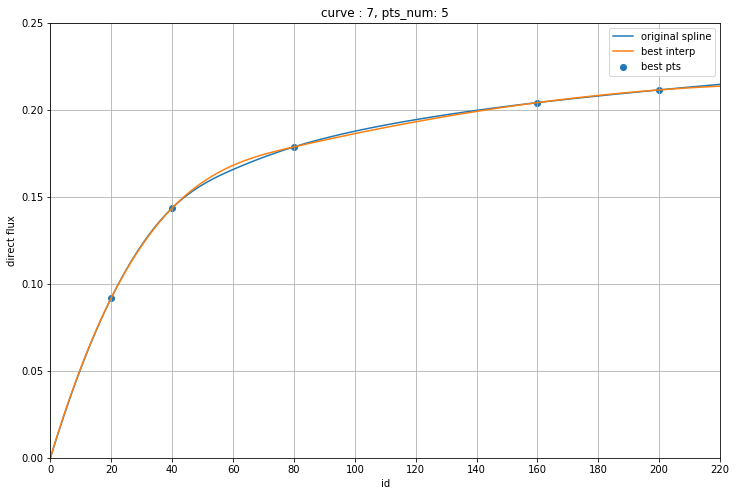

curve: 7, pts num: 4


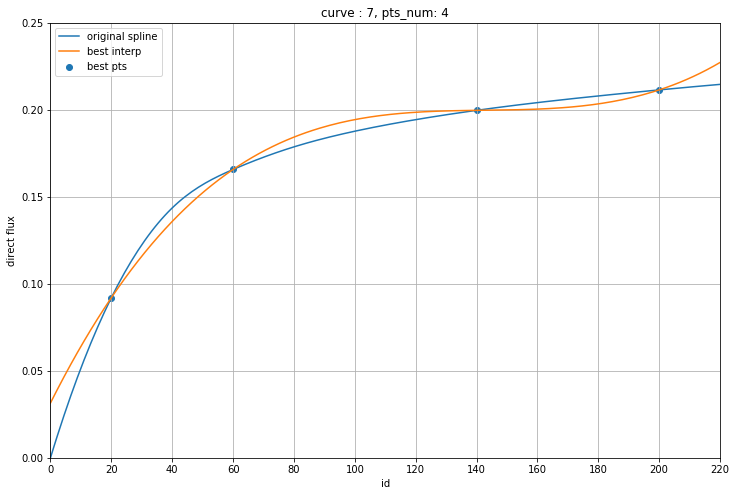

curve: 9, pts num: 6


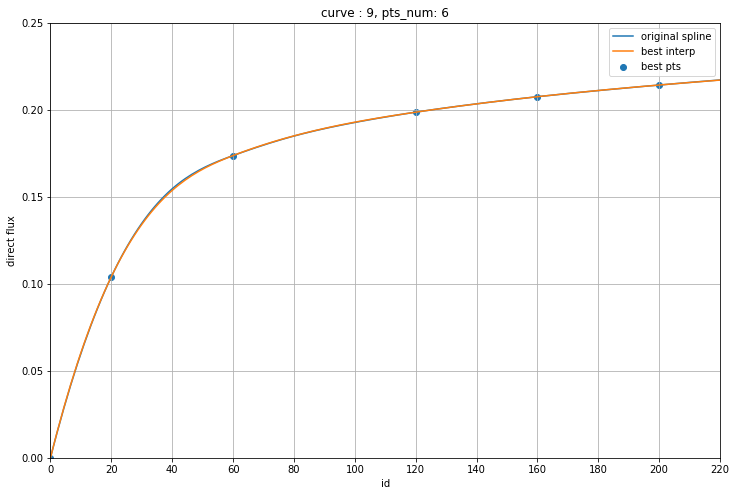

curve: 9, pts num: 5


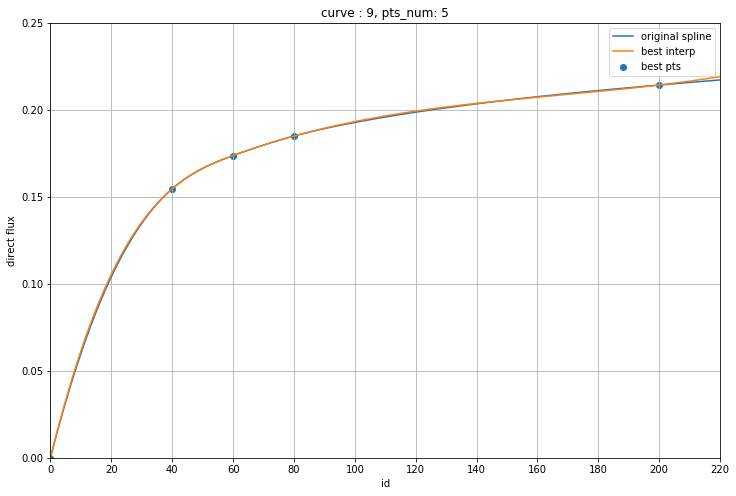

curve: 9, pts num: 4


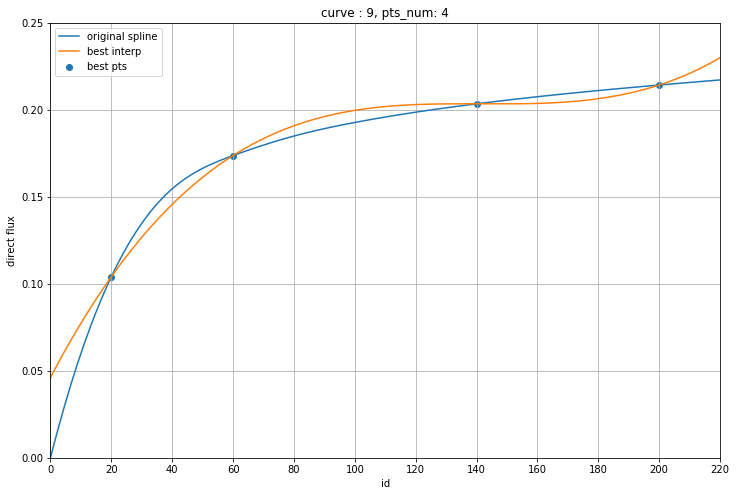

curve: 11, pts num: 6


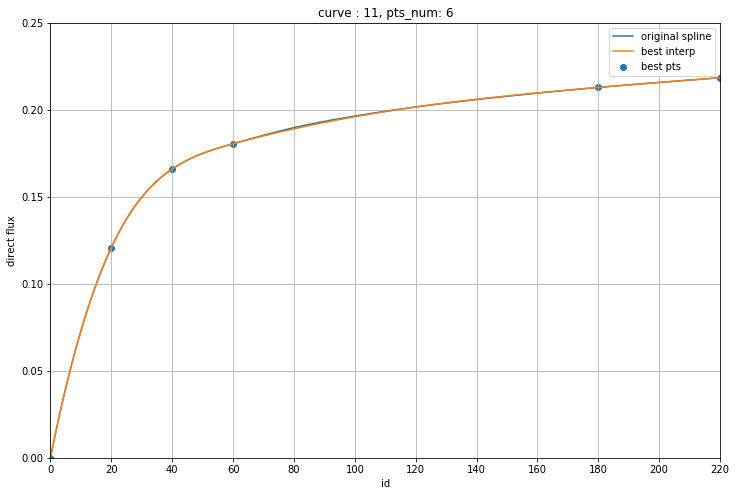

curve: 11, pts num: 5


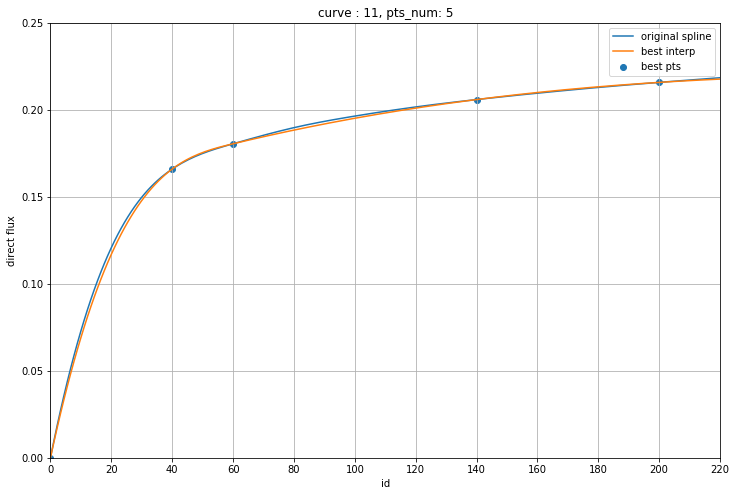

curve: 11, pts num: 4


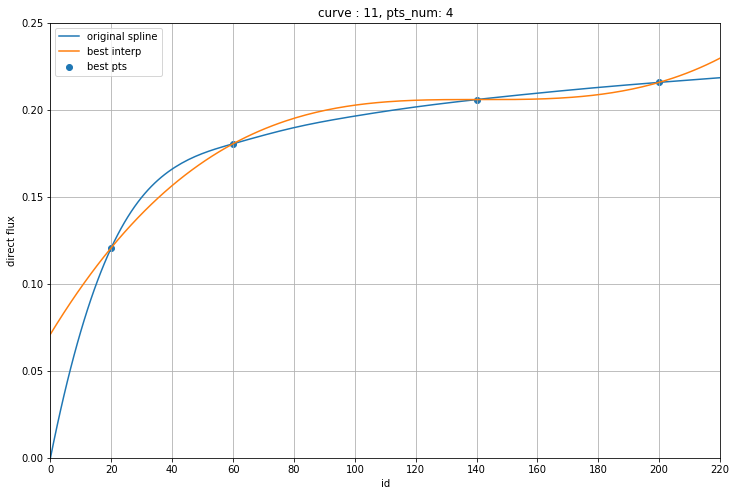

Interpolation error ( sum squared error * 10 ^ 6)
+-----------+-------------+------------+------------+------------+------------+------------+------------+----------------------------------+
| curve idx | pts num: 10 | pts num: 9 | pts num: 8 | pts num: 7 | pts num: 6 | pts num: 5 | pts num: 4 |  ########## 5_best_pts ######### |
+===========+=============+============+============+============+============+============+============+==================================+
| curve 0   | 0.00015     | 0.00024    | 0.00039    | 0.00442    | 0.05731    | 0.95977    | 13.82680   | [  40.   60.  100.  180.  200.]  |
+-----------+-------------+------------+------------+------------+------------+------------+------------+----------------------------------+
| curve 1   | 0.00008     | 0.00008    | 0.00035    | 0.00203    | 0.19464    | 0.34677    | 20.11968   | [  40.   60.  100.  140.  200.]  |
+-----------+-------------+------------+------------+------------+------------+------------+------------

In [115]:
from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

curves_for_plot = list(range(1, 13, 2))
pts_for_plot = [4, 5, 6]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = range(len(ids)-2, 3, -1)

headers = ['curve idx'] + ['pts num: %d' % pts for pts in sub_points_num] + [' ########## 5_best_pts #########']
rows = []

for curve in curve_indices:
    y = dfs[:, curve]
    x = ids
        
    tck = interpolate.splrep(x, y, s=0)
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['curve %d' % curve]
    best_5_pts = []

    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, y_new)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
            tck_   = interpolate.splrep(x_, y_, s=0)
            y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_)
                best_interp = (x_new, y_new_)
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
        
        if points_num == 5:
            best_5_pts = best_pts[0]
            
        row.append(best_err_gr)
        
        if curve in curves_for_plot and points_num in pts_for_plot:
            print('curve: %d, pts num: %d' % (curve, points_num))
            plt.clf()
#             plt.scatter(x, y, label='orig points')
            plt.plot(x_new, baseline, label='original spline')
            plt.scatter(best_pts[0], best_pts[1], label='best pts')
            plt.plot(best_interp[0], best_interp[1], label='best interp')

            plt.ylim([0, 0.25])
            plt.xlim([0, 220])
            plt.xticks(ids)
            plt.xlabel('id')
            plt.ylabel('direct flux')
            plt.legend(loc='best')
            plt.title('curve : %d, pts_num: %d' % (curve, points_num))
            plt.grid()
            plt.show()
    
    row.append(best_5_pts)
    rows.append(row)

print('Interpolation error ( sum squared error * 10 ^ 6)')
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)